# Visualizing mutual fund portfolio overlaps with other indices and mutual fund portfolios

We had discussed Upset charts for visualizing fund portfolio overlaps in [Mutual fund portfolio overlap in UpSet charts](https://stockviz.biz/2018/10/22/mutual-fund-portfolio-overlap-in-upset-charts/). You can use the code below to roll your own overlap analysis for the funds you care about.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)
library(UpSetR)
library(grid)

options(repr.plot.width=16, repr.plot.height=8)

indices <- Indices()
mfi <- MutualFundsIndia()

The *Franklin India Prima* fund is a mid-cap fund. We will see how the portfolio is actually setup by intersecting it with both large-cap and mid-cap index portfolios.

In [5]:
indexName1 <- "NIFTY 100" #large-cap universe
indexName2 <- "NIFTY MIDCAP 150" #mid-cap universe
schemeCode <- 100473
schemeName <- "Franklin India Prima"
portfolioDate <- as.Date("2019-07-31")

In [6]:
# grab the data
mfPortfolio <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == portfolioDate
           & (INSTRUMENT_TYPE == 'STOCK' 
              | INSTRUMENT_TYPE == 'E' 
              | INSTRUMENT_TYPE == '' 
              | is.null(INSTRUMENT_TYPE))) %>%
    select(SYMBOL, WEIGHTAGE) %>%
    arrange(desc(WEIGHTAGE)) %>%
    collect()

indexPort1 <- indices$NseConstituents() %>%
    filter(NAME == indexName1) %>%
    select(SYMBOL, CAP_WEIGHT) %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()

indexPort2 <- indices$NseConstituents() %>%
    filter(NAME == indexName2) %>%
    select(SYMBOL, CAP_WEIGHT) %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()

mfPortfolio %>% print(n=5)
indexPort1 %>% print(n=5)
indexPort2 %>% print(n=5)

# A tibble: 62 x 2
  SYMBOL    WEIGHTAGE
* <chr>         <dbl>
1 HDFCBANK       3.53
2 KOTAKBANK      3.07
3 RAMCOCEM       3.02
4 KANSAINER      2.90
5 NAUKRI         2.81
# … with 57 more rows
# A tibble: 100 x 2
  SYMBOL    CAP_WEIGHT
* <chr>          <dbl>
1 HDFCBANK        9.36
2 RELIANCE        8.34
3 HDFC            7.03
4 INFY            5.92
5 ICICIBANK       5.12
# … with 95 more rows
# A tibble: 150 x 2
  SYMBOL     CAP_WEIGHT
* <chr>           <dbl>
1 FEDERALBNK       2.05
2 RBLBANK          1.83
3 NAUKRI           1.78
4 CUB              1.78
5 VOLTAS           1.77
# … with 145 more rows


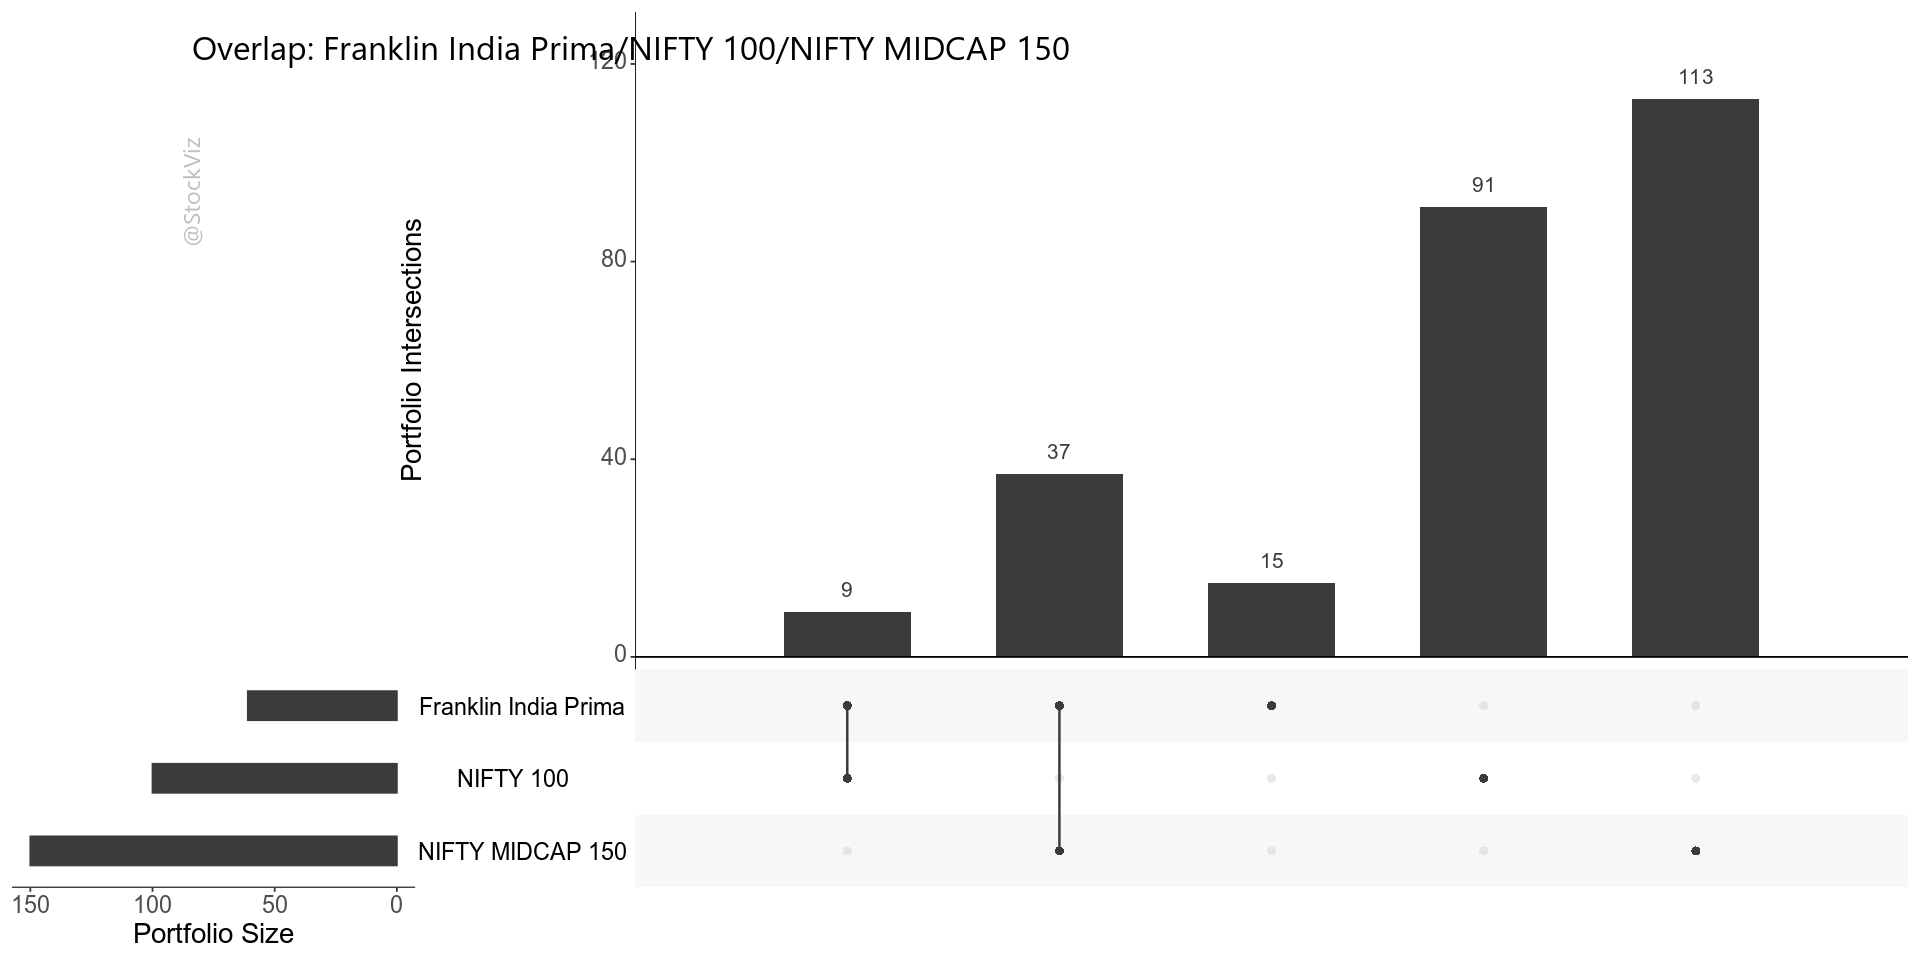

In [7]:
# create the chart

#UpSetR takes a list
listInput <- list(mfPortfolio$SYMBOL, indexPort1$SYMBOL, indexPort2$SYMBOL)
names(listInput) <- c(schemeName, indexName1, indexName2)

upset(fromList(listInput), order.by='degree', nsets=length(listInput), keep.order=T, mainbar.y.label='Portfolio Intersections', sets.x.label ='Portfolio Size', text.scale=2)
grid.text(sprintf("Overlap: %s/%s/%s", schemeName, indexName1, indexName2),x = 0.1, y=0.95, just='left', gp=gpar(fontsize=20, fontfamily='Segoe UI'))
grid.text("@StockViz",x = 0.1, y=0.8, rot=90, gp=gpar(fontsize=14, fontfamily='Segoe UI', col='grey'))

### what are the names that intersect?

In [8]:
print(indexName1)
mfPortfolio %>%
    inner_join(indexPort1) %>%
    mutate(DIFF = WEIGHTAGE - CAP_WEIGHT) %>% 
    arrange(desc(DIFF)) %>%
    print(n = Inf)

print(indexName2)
mfPortfolio %>%
    inner_join(indexPort2) %>%
    mutate(DIFF = WEIGHTAGE - CAP_WEIGHT) %>% 
    arrange(desc(DIFF)) %>%
    print(n = Inf)

[1] "NIFTY 100"


# A tibble: 9 x 4
  SYMBOL    WEIGHTAGE CAP_WEIGHT   DIFF
  <chr>         <dbl>      <dbl>  <dbl>
1 BPCL          1.81      0.550   1.26 
2 ASHOKLEY      1.38      0.178   1.20 
3 PETRONET      1.39      0.369   1.02 
4 CADILAHC      0.837     0.112   0.725
5 IDEA          0.547     0.0796  0.467
6 HINDALCO      0.962     0.517   0.446
7 YESBANK       0.668     0.247   0.422
8 KOTAKBANK     3.07      3.84   -0.766
9 HDFCBANK      3.53      9.36   -5.83 
[1] "NIFTY MIDCAP 150"


# A tibble: 37 x 4
   SYMBOL     WEIGHTAGE CAP_WEIGHT    DIFF
   <chr>          <dbl>      <dbl>   <dbl>
 1 KANSAINER   2.90          0.788  2.12  
 2 FINCABLES   2.32          0.348  1.98  
 3 RAMCOCEM    3.02          1.21   1.81  
 4 WABCOINDIA  2.08          0.359  1.72  
 5 SKFINDIA    2.16          0.556  1.61  
 6 OBEROIRLTY  2.22          0.757  1.47  
 7 PNBHOUSING  1.95          0.489  1.46  
 8 GSPL        2.15          0.779  1.37  
 9 TORNTPOWER  1.80          0.587  1.21  
10 INDHOTEL    2.42          1.21   1.21  
11 EMAMILTD    1.77          0.618  1.15  
12 PIIND       2.01          0.947  1.06  
13 TATACHEM    2.29          1.24   1.05  
14 NAUKRI      2.81          1.78   1.03  
15 CUB         2.81          1.78   1.02  
16 COROMANDEL  1.50          0.496  1.00  
17 CROMPTON    2.07          1.17   0.899 
18 APOLLOTYRE  1.60          0.706  0.895 
19 AIAENG      1.57          0.777  0.792 
20 CHOLAHLDNG  1.28          0.544  0.738 
21 VOLTAS      2.45          1.77  

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)